## 3. Modeling

We will attempt the following models:

- Logistics Regression with Penalty
- Soft-margin SVM
- Decision Tree
- XG-boost

For each model, we will assess the performance on:

- Accuracy. Cross validation & ROC curve.
- Intepretability. Feature importance(sign, magnitude, elasticity) & decision boundary.
- Efficiency. Time of execution vs. theoretical computational efficiency.
- Stability. Model under perturbance in input. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from sklearn.metrics import roc_auc_score

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option("display.max_columns", 40)

In [2]:
#conda install -c conda-forge imbalanced-learn # worked for me

In [3]:
training = pd.read_csv("../data/training_for_prediction_numerical.csv")
test = pd.read_csv("../data/test_for_prediction_numerical.csv")
# training.drop(columns = [ 'car', 'credit_card', 'debt_consolidation',
#        'educational', 'home_improvement', 'house', 'major_purchase', 'medical',
#        'moving', 'renewable_energy', 'small_business', 'vacation', 'wedding'], inplace=True)
# test.drop(columns = [ 'car', 'credit_card', 'debt_consolidation',
#        'educational', 'home_improvement', 'house', 'major_purchase', 'medical',
#        'moving', 'renewable_energy', 'small_business', 'vacation', 'wedding'], inplace=True)

In [4]:
X_train = training.iloc[: ,1:]
y_train = training.iloc[: ,0]
X_test = test.iloc[: ,1:]
y_test = test.iloc[: ,0]

### 0. ROC curve

There are two ways to look at the ROC curve: its Area Under the Curve represents the probability that the classifier ranks a positive instance higher than a negative instance, and each point on the curve represents the (fpr, tpr) corresponding to that threshold. Using AUC, we can differentiate between models; using the graph itself, we can find the best threshold for converting "estimated probability" to labels.


http://mlwiki.org/index.php/ROC_Analysis

$$\text{tpr} = \cfrac{\text{acc} - \text{neg}}{\text{pos}} + \cfrac{\text{neg}}{\text{pos}} \cdot \text{fpr}$$

Takeaway from the above formula: the more unbalanced the data is (the greater $\frac{neg}{pos}$ is), the faster the true positive rate has to rise against the false positive rate for a non-trivial classifier to be optimal.


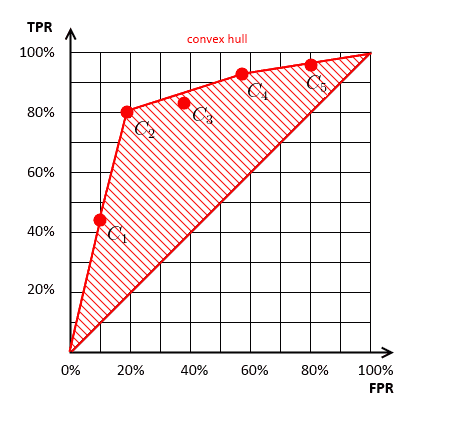

In [5]:
## Defining Confusion Matrix
# Assuming we are taking in 2 np.arrays, with 1 indicating default, 0 non-default.
def confusion_matrix(y_actual, y_predicted):
    y_actual = np.array(y_actual)
    y_predicted = np.array(y_predicted)
    tp = ((y_actual == 1) & (y_predicted == 1)).sum()
    fp = ((y_actual == 0) & (y_predicted == 1)).sum()
    fn = ((y_actual == 1) & (y_predicted == 0)).sum()
    tn = ((y_actual == 0) & (y_predicted == 0)).sum()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    result = pd.DataFrame({"Actual True" : [tp, fn], "Actual False": [fp, tn]})
    result.rename(index = {0:"Predicted True", 1:"Predicted False"}, inplace=True)
    return result

def get_tpr_fpr(confusion_matrix):
    tpr = confusion_matrix.iloc[0,0]/(confusion_matrix.iloc[0,0] + confusion_matrix.iloc[1,0])
    fpr = confusion_matrix.iloc[0,1]/(confusion_matrix.iloc[0,1] + confusion_matrix.iloc[1,1])
    return {"tpr":tpr, "fpr":fpr}

def get_accuracy(y_actual, y_predicted):
    y_actual = np.array(y_actual)
    y_predicted = np.array(y_predicted)
    return (y_actual == y_predicted).mean()

def get_tpr(y_actual, y_predicted):
    y_actual = np.array(y_actual)
    y_predicted = np.array(y_predicted)
    tp = ((y_actual == 1) & (y_predicted == 1)).sum()
    fp = ((y_actual == 0) & (y_predicted == 1)).sum()
    fn = ((y_actual == 1) & (y_predicted == 0)).sum()
    tn = ((y_actual == 0) & (y_predicted == 0)).sum()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr

def get_fpr(y_actual, y_predicted):
    y_actual = np.array(y_actual)
    y_predicted = np.array(y_predicted)
    tp = ((y_actual == 1) & (y_predicted == 1)).sum()
    fp = ((y_actual == 0) & (y_predicted == 1)).sum()
    fn = ((y_actual == 1) & (y_predicted == 0)).sum()
    tn = ((y_actual == 0) & (y_predicted == 0)).sum()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return fpr

## Getting default probability for 
def get_default_prob(predicted_proba):
    temp = pd.DataFrame(predicted_proba)
    return np.array(temp[1])

In [6]:
## Get the accuracy, tpr, fpr for using each threshold
def get_results(y_actual, X, fitted_model):
    default_prob = get_default_prob(fitted_model.predict_proba(X))
    result = pd.DataFrame({
        "true_label": y_actual,
        "predicted_probability": default_prob
    })
    result.sort_values("predicted_probability", inplace=True)
    performances = threshold_performances(result)
    result["threshold_accuracies"] = performances[0]
    result["threshold_tprs"] = performances[1]
    result["threshold_fprs"] = performances[2]
    return result

def threshold_performance(result, threshold):
    predicted_labels = (result["predicted_probability"] >= threshold).astype(int)
    accuracy = get_accuracy(result["true_label"], predicted_labels)
    tpr = get_tpr(result["true_label"], predicted_labels)
    fpr = get_fpr(result["true_label"], predicted_labels)
    return [accuracy, tpr, fpr]

def threshold_performances(result):
    accuracies = []
    tprs = []
    fprs = []
    for p in result["predicted_probability"]:
        performance = threshold_performance(result, p)
        accuracies.append(performance[0])
        tprs.append(performance[1])
        fprs.append(performance[2])
    return np.array([accuracies, tprs, fprs])

def get_best_threshold(result):
    return result[result["threshold_accuracies"] == result["threshold_accuracies"].max()]

def get_prediction(X_test, fitted_model, threshold):
    predicted_prob = get_default_prob(fitted_model.predict_proba(X_test))
    return (predicted_prob > threshold).astype(int)

In [7]:
# Up sampling
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [8]:
## Baseline predictor:
penalty = ['l2']
C = np.logspace(-1, 4, 5)
hyperparameters = dict(C=C, penalty=penalty)
base_clf = linear_model.LogisticRegression()
logistic_unbalanced = GridSearchCV(base_clf, hyperparameters, cv=5, verbose=0)
logistic_unbalanced.fit(X_train, y_train)
logistic_unbalanced.score(X_train, y_train)

C:\Users\nleea\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\nleea\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\nleea\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\nleea\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-01, 1.77827941e+00, 3.16227766e+01, 5.62341325e+02,
       1.00000000e+04]),
                         'penalty': ['l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

0.8613354786806114

In [9]:
## Baseline predictor with balanced weights:
penalty = ['l2']
C = np.logspace(-1, 4, 5)
hyperparameters = dict(C=C, penalty=penalty)
base_clf2 = linear_model.LogisticRegression(class_weight="balanced")
logistic_balanced = GridSearchCV(base_clf2, hyperparameters, cv=5, verbose=0)
logistic_balanced.fit(X_train, y_train)
logistic_balanced.score(X_train, y_train)

C:\Users\nleea\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\nleea\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-01, 1.77827941e+00, 3.16227766e+01, 5.62341325e+02,
       1.00000000e+04]),
                         'penalty': ['l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

0.5542075623491552

### Sanity Check: Dummy Classifier

In [10]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
result_dummy = get_results(y_train, X_train, dummy)
dummy_preds = dummy.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, dummy_preds)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

0.5

Text(0.5, 1.0, 'ROC curve for Dummy Classifier Thresholds')

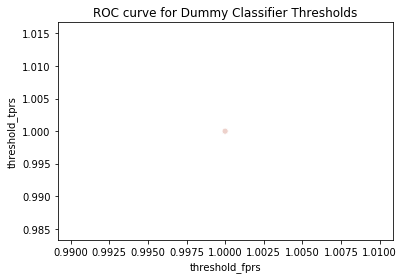

In [11]:
index = np.random.choice(result_dummy.shape[0], size=result_dummy.shape[0]//30)
sns.scatterplot(data=result_dummy.loc[index, :], x="threshold_fprs", y="threshold_tprs", hue="threshold_accuracies", legend=False)
plt.title("ROC curve for Dummy Classifier Thresholds")

### 1. Comparing logistics regression with balanced and unbalanced class weight

In [12]:
%%time
result_logistics_balanced = get_results(y_train, X_train, logistic_balanced)
result_logistics_unbalanced = get_results(y_train, X_train, logistic_unbalanced)

Wall time: 1min 37s


In [13]:
get_best_threshold(result_logistics_balanced)
get_best_threshold(result_logistics_unbalanced)

,true_label,predicted_probability,threshold_accuracies,threshold_tprs,threshold_fprs
2192,0,0.699923,0.861303,0.0,0.000037


,true_label,predicted_probability,threshold_accuracies,threshold_tprs,threshold_fprs
18017,1,0.404261,0.861368,0.000232,0.0


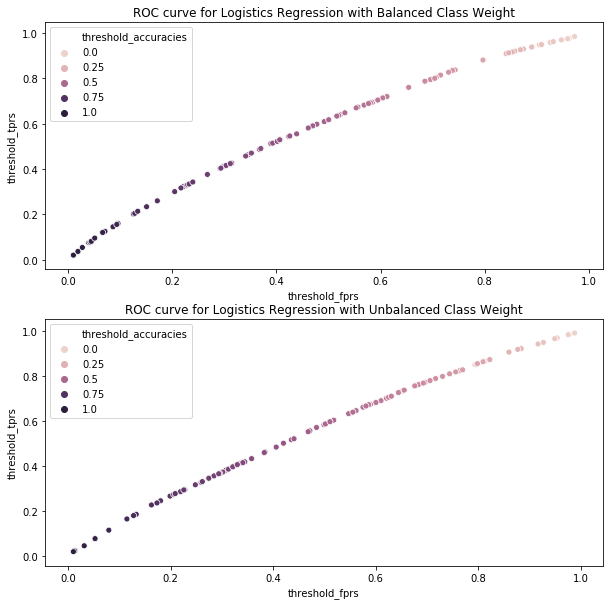

In [16]:
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(211)
index = np.random.choice(result_logistics_balanced.shape[0], size=result_logistics_balanced.shape[0]//300)
sns.scatterplot(data=result_logistics_balanced.loc[index, :], x="threshold_fprs", y="threshold_tprs", hue="threshold_accuracies", ax=ax1)
ax1.set_title("ROC curve for Logistics Regression with Balanced Class Weight")
ax2 = plt.subplot(212)
sns.scatterplot(data=result_logistics_unbalanced.loc[index, :], x="threshold_fprs", y="threshold_tprs", hue="threshold_accuracies", ax=ax2)
ax2.set_title("ROC curve for Logistics Regression with Unbalanced Class Weight")
plt.show();

In [17]:
roc_auc_score(y_train, logistic_balanced.predict_proba(X_train)[:, 1])
roc_auc_score(y_train, logistic_unbalanced.predict_proba(X_train)[:, 1])

0.5866039320310678

0.5599966910216972

### 2. Decision Trees and Random Forest

In [18]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
%%time
param_grid = {'max_depth': np.arange(3,10), 'criterion' :['gini', 'entropy']}
tree = GridSearchCV(DecisionTreeClassifier(), param_grid)
tree.fit(X_train, y_train)


Wall time: 13.1 s


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                

In [26]:
tree_preds = tree.predict_proba(X_train)[:, 1]
tree_performance = roc_auc_score(y_train, tree_preds)
tree_performance

0.6407952146645484

In [27]:
%%time
result_tree = get_results(y_train, X_train, tree)

Wall time: 48.1 s


In [22]:
get_best_threshold(result_tree)

,true_label,predicted_probability,threshold_accuracies,threshold_tprs,threshold_fprs
23106,1,0.396135,0.859952,0.01903,0.00467
13026,1,0.396135,0.859952,0.01903,0.00467
12253,0,0.396135,0.859952,0.01903,0.00467
13296,0,0.396135,0.859952,0.01903,0.00467
17041,1,0.396135,0.859952,0.01903,0.00467
...,...,...,...,...,...
6196,0,0.396135,0.859952,0.01903,0.00467
6184,1,0.396135,0.859952,0.01903,0.00467
6179,0,0.396135,0.859952,0.01903,0.00467
16008,1,0.396135,0.859952,0.01903,0.00467


Text(0.5, 1.0, 'ROC curve for Decision Tree')

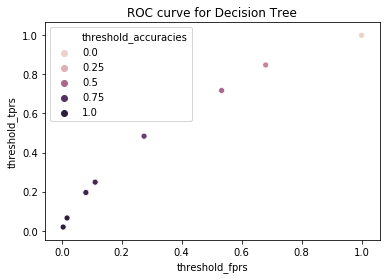

In [24]:
index = np.random.choice(result_tree.shape[0], size=result_tree.shape[0])
sns.scatterplot(data=result_tree.loc[index, :], x="threshold_fprs", y="threshold_tprs", hue="threshold_accuracies")
plt.title("ROC curve for Decision Tree")

In [33]:
confusion_matrix(y_train, logistic_balanced.predict(X_train))

,Actual True,Actual False
Predicted True,2443,11987
Predicted False,1866,14779


In [34]:
y_test.size

3563